# Comparison of span vs other peak calling tools

## Сomparison method

Method based on F score described in original paper:
Koohy H, Down TA, Spivakov M, Hubbard T (2014) 
A Comparison of Peak Callers Used for DNase-Seq Data. 
PLoS ONE 9(5): e96303. doi:10.1371/journal.pone.0096303

http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0096303

## Requirements

* span-0.11.*.jar
* java8
* bedtools
* wget
* awk
* ~20G free space to download all the required bed and bam files

In [ ]:
import os
import sys
from os import listdir
def run(cmd):
    print(cmd)
    if os.system(cmd) != 0:
        sys.exit(1)

Lets download all the "Reference peaks set" mentioned in http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0096303



In [ ]:
run('wget "http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007" \
-O supplementary.zip')
run('unzip -x supplementary.zip')

Now that we have Supplemetary_Data/GM12878.txt, etc, we can download all the peaks automatically.
Files are available here: http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007

In [ ]:
import pandas as pd
RESOURCE = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeSydhTfbs'
CELLS = ['GM12878', 'HelaS3', 'K562']
for cell in CELLS:
    print "Processing {0}".format(cell)
    os.mkdir(cell)
    df = pd.read_csv('Supplementary_Data/{0}.txt'.format(cell), sep=' ', header=None)
    df.columns = ['file', 'checksum']
    for f in df['file']:
        run('wget {0}/{1} -P {2}'.format(RESOURCE, f, cell))

Now we should all the refernce peaks using Bedops as described in the article, however Bedops FAILS with segfault.

Bedtools for the rescue!

In [ ]:
# Lets merge them and filter chr22 to get reference peaks
CELLS = ['GM12878', 'HelaS3', 'K562']
run('mkdir peaks')
for cell in CELLS:
    run('cat {0}/*.gz > {0}_all.bed'.format(cell))
    run('bedtools sort -i {0}_all.bed > {0}_sorted.bed'.format(cell))
    run('bedtools merge -i {0}_sorted.bed > {0}_peaks.bed'.format(cell))
    run('awk \'$1=="chr22" {{print}}\' {0}_peaks.bed > peaks/{0}_peaks_chr22.bed'.format(cell))
run('rm *_all.bed *_sorted.bed *_peaks.bed')

Download and convert reads.

In [ ]:
run('wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/\
wgEncodeUwDnaseK562AlnRep1.bam -O K562.bam')
run('wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/\
wgEncodeUwDnaseGm12878AlnRep1.bam -O GM12878.bam')
run('wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/\
wgEncodeUwDnaseHelas3AlnRep1.bam -O HelaS3.bam')

# Lets convert downloaded bam files to bed
for bam in [f for f in listdir('.') if f.endswith(".bam")]:
    run('bamToBed -bed12 -i {0} > {0}.bed'.format(bam))

Now we can launch span to get enrichment for obtained bed tracks.

In [ ]:
run ('wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.2bit')
run('mkdir span')
FDRS = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]
for reads in [f for f in listdir('.') if f.endswith(".bam.bed")]:
    for fdr in FDRS: 
        print 'Processing {0} FDR={1}'.format(reads, fdr)
        run('java -jar span-0.11.jar analyze -r ./hg19.2bit \
-i {0} --bed span/{0}_{1}_span_chr22.bed --fdr {1} --only chr22'.format(reads, fdr))

Let us perform intersection of reference peaks with span ones.

In [ ]:
import pandas as pd

def bed_length(cell_file):
    run('awk \'{{SUM += $3-$2}} END {{print SUM}}\' {0} > length_file.txt'.format(cell_file))
    l = pd.read_csv('length_file.txt', header=None)[0][0]
    run('rm length_file.txt')
    return l
    
from pandas import DataFrame
results = DataFrame(columns=['cell', 'fdr', 'ref_length', 'span_length', 'intersection_length'])
for cell in CELLS:
    cell_file = 'peaks/{0}_peaks_chr22.bed'.format(cell)
    cell_peaks_length = bed_length(cell_file)    
    
    for reads in [f for f in listdir('.') if f.endswith(".bam.bed")]:
        for fdr in FDRS: 
            file = 'span/{0}_{1}_span_chr22.bed'.format(reads, fdr)
            if (cell not in file):
                continue
            span_length = bed_length(file)
            intersection_file = 'peaks/intersection_{0}_{1}.bed'.format(cell, fdr)
            run('bedtools intersect -a {0} -b {1} > {2}'.format(cell_file, file, intersection_file))
            intersection_length = bed_length(intersection_file)
            results.loc[len(results)] = [cell, fdr, cell_peaks_length, span_length, intersection_length]

Now that we have both reference peaks, span output and their intersection length, we can compute `TP`, `FP` and `FN` values.

In [ ]:
results['TP'] = results['intersection_length']
results['FP'] = results['span_length'] - results['intersection_length']
results['FN'] = results['ref_length'] - results['intersection_length']
results['Spec'] = results['TP'] / (results['TP'] + results['FP'])
results['Sen'] = results['TP'] / (results['TP'] + results['FN'])
results.head(1)

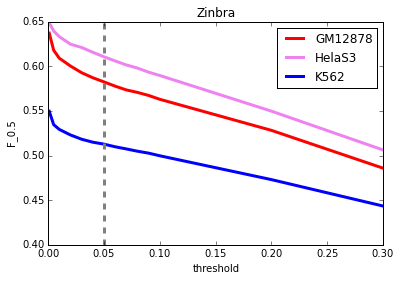

In [10]:
CELLS = ['GM12878', 'HelaS3', 'K562']
def Fb(b, spec, sen):
    return (1 + b*b) * spec * sen / (b * b * spec + sen)

Beta = 0.5
%matplotlib inline
import matplotlib.pyplot as plt
colors = {'GM12878': 'red', 'K562': 'blue', 'HelaS3':'violet'}
plt.title('SPAN')
plt.xlabel('threshold')
plt.ylabel('F_0.5')
for cell in CELLS:
    r = results[results['cell'] == cell]
    plt.plot(r['fdr'], Fb(Beta, r['Spec'], r['Sen']), linewidth=3.0, c=colors[cell], label=cell)
plt.axvline(x=0.05, linewidth=3.0, c='grey', linestyle='--')
plt.legend()
plt.show()

### Now we are ready to compare performance score F
<img src="http://journals.plos.org/plosone/article/figure/image?size=large&id=info:doi/10.1371/journal.pone.0096303.g006">